In [2]:
import sys
import pickle
import matplotlib.pyplot as plt

from pathlib import Path

from dotenv import find_dotenv, load_dotenv
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv())

PROJ_ROOT = Path('/home/bruno-pacheco/brain-age')

from tqdm.notebook import tqdm

import numpy as np

In [3]:
from brats.utils import show_mri

220704-16:01:48,610 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.6.0


In [4]:
import wandb

import torch
from torchvision import models
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_from_wandb(net: nn.Module, run_id: str,
                    project='ADNI-brain-age', model_fname='model_last'):
    best_model_file = wandb.restore(
        model_fname+'.pth',
        run_path=f"gama/{project}/{run_id}",
        replace=True
    )
    net.load_state_dict(torch.load(best_model_file.name))

    return net

class BraTSnnUNet(nn.Module):
    def __init__(self, network, freeze=False):
        """`network` must be a nnU-Net `Generic_UNet`.
        """
        super().__init__()

        self.brats_encoder = network.conv_blocks_context

        self.pooling = nn.AvgPool2d(5)

        self.fc = nn.Linear(480,1)

        if freeze:
            self.freeze()

    def forward(self, x):
        for d in range(len(self.brats_encoder)):
            x = self.brats_encoder[d](x)

        x = self.pooling(x)

        y = self.fc(x.squeeze()).squeeze()

        return y

    def freeze(self):
        for param in self.brats_encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.brats_encoder.parameters():
            param.requires_grad = True

In [5]:
import h5py

from torch.utils.data import Dataset
from torchvision import transforms


class ADNIDatasetForBraTSModel(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=transforms.ToTensor(),
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        with h5py.File(self._fpath, 'r') as h:
            img = h[self.dataset]['X'][index]
            label = h[self.dataset]['y'][index]

        # transform
        if self.transform:
            img = self.transform(img)

        return img, label

val_data = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix_2mm_split.hdf5', dataset='val')
len(val_data) / 40

561.0

In [189]:
def compute_scores(Y_pred, Y):
    image_MAE = np.abs(Y_pred - Y).mean()
    subject_Y_pred = Y_pred.mean(axis=-1)
    subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

    print(f"Per-image MAE   = {image_MAE:.4f}")
    print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
    print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

def show_pred(subject_Y_pred, Y):
    mae = np.abs(subject_Y_pred - Y).mean()
    plt.suptitle(f'Per-subject predictions (MAE = {mae:.3f})')
    plt.scatter(Y, subject_Y_pred, s=3, marker='x', alpha=0.5)
    # plt.scatter(Y, subject_Y_pred - Y, s=3, marker='x', alpha=0.5)
    xlim = plt.xlim()
    ylim = plt.ylim()

    plt.plot([0.,100.],[0.,100.], 'r', label='ideal')

    a, b = np.polyfit(subject_Y_pred, Y, 1)
    plt.plot([b, a * 100 + b], [0, 100], label='best fit')

    plt.xlim([50, 100])
    plt.ylim([50, 100])

    plt.xlabel('True age')
    plt.ylabel('Predicted age')
    # plt.ylabel('Error')
    plt.gcf().set_size_inches((6,6))
    plt.legend()
    plt.grid()
    plt.show()

In [100]:
def make_postprocessor(Y_pred, Y):  # expects Y_pred and Y at subject level
    from sklearn.linear_model import SGDRegressor
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler

    reg = make_pipeline(StandardScaler(), SGDRegressor(loss='epsilon_insensitive'))
    reg = reg.fit(Y_pred.reshape(-1,1), Y)

    return lambda y: reg.predict(y.reshape(-1,1))

import torch

def make_postprocessor_mlp(Y_pred, Y):  # expects Y_pred and Y at subject level
    model = torch.nn.Linear(1,1)
    optim = torch.optim.SGD(model.parameters(), lr=.1)

    loss_fun = torch.nn.L1Loss()

    X = (torch.from_numpy(Y_pred.reshape(-1,1)) - 50) / 50
    y = (torch.from_numpy(Y) - 50) / 50

    error = list()
    model.train()
    for epoch in range(1000):
        optim.zero_grad()

        y_pred = model(X).squeeze()

        loss = loss_fun(y_pred, y)

        loss.backward()
        optim.step()

        error.append(loss.item())
    
    model.eval()
    return lambda y: model((torch.from_numpy(y.reshape(-1,1)) - 50) / 50).squeeze().detach().numpy() * 50 + 50

# 2 mm³

In [5]:
val_data = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix_2mm_split.hdf5', dataset='val')
len(val_data)

22440

## Pre-Trained

### BraTS-nnUNet

In [88]:
net = torch.load('/home/bruno-pacheco/brain-age/models/brats_model.pt')
net.pooling = nn.AvgPool2d(3)
net = load_from_wandb(net, '32j2aq8b').to(device)
net.eval()
net

KeyboardInterrupt: 

In [7]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=40, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

Y = np.stack(Y)
Y_pred = np.stack(Y_pred)

# some subjects are 0-aged
# Y_pred = Y_pred[(Y != 0).any(axis=-1)]
# Y = Y[(Y != 0).any(axis=-1)]

Per-image MAE   = 3.6157
Per-subject MAE = 3.1247 (mean agg)
Per-subject MAE = 3.1483 (median agg)


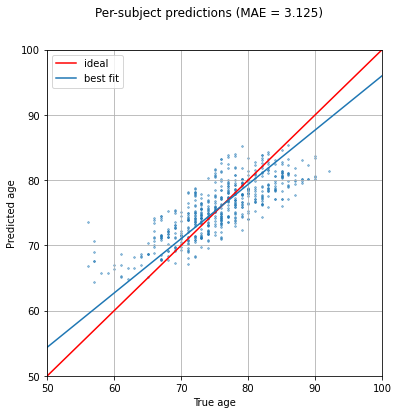

In [338]:
# Ys = {
#     'pred': Y_pred,
#     'true': Y
# }
# with open(PROJ_ROOT/'data/preds/unet_brats.pkl', 'wb') as f:
#     pickle.dump(Ys, f)

with open(PROJ_ROOT/'data/preds/unet_brats.pkl', 'rb') as f:
    Ys = pickle.load(f)

Y = Ys['true']
Y_pred = Ys['pred']

compute_scores(Y_pred, Y)

show_pred(Y_pred.mean(axis=-1), Y[:,0])

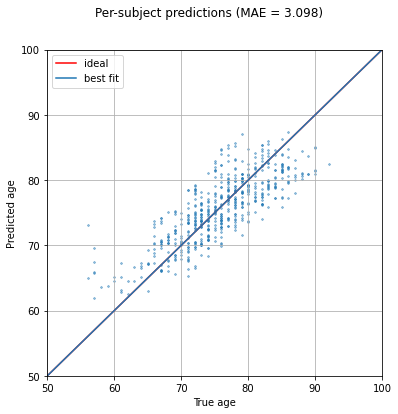

In [191]:
a, b = np.polyfit(Y_pred.mean(axis=-1), Y[:,0], 1)
adjusted_Y_pred = Y_pred.mean(axis=-1) * a + b

show_pred(adjusted_Y_pred, Y[:,0])

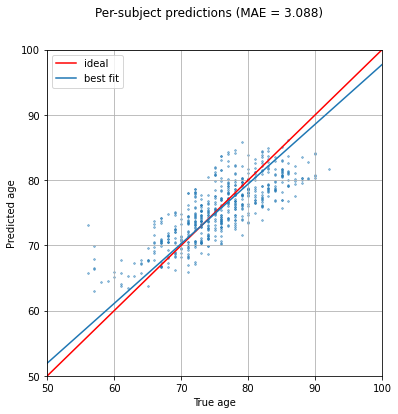

In [192]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

reg = make_pipeline(StandardScaler(), SGDRegressor(loss='epsilon_insensitive'))
reg = reg.fit(Y_pred.mean(axis=-1).reshape(-1,1), Y[:,0])

show_pred(reg.predict(Y_pred.mean(axis=-1).reshape(-1,1)), Y[:,0])

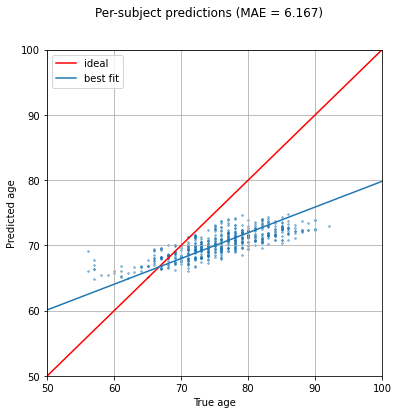

In [193]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

reg = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', max_iter=100000))
reg = reg.fit(Y_pred.mean(axis=-1).reshape(-1,1), Y[:,0])

show_pred(reg.predict(Y_pred.mean(axis=-1).reshape(-1,1)), Y[:,0])

In [194]:
adjusted_Y_pred = QuantReg(Y[:,0], Y_pred.mean(axis=-1).reshape(-1,1)).fit(0.5).predict()
show_pred(adjusted_Y_pred, Y[:,0])

NameError: name 'QuantReg' is not defined

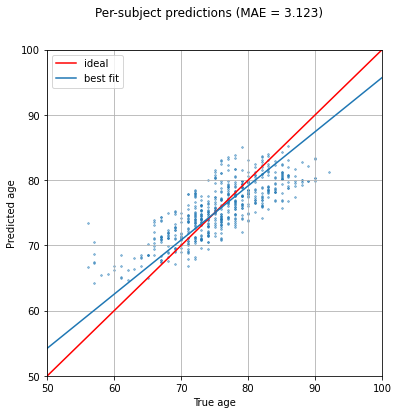

In [195]:
from sklearn.linear_model import QuantileRegressor

# reg = make_pipeline(StandardScaler(),
reg = QuantileRegressor(quantile=0.5, fit_intercept=False)
reg = reg.fit(Y_pred.mean(axis=-1).reshape(-1,1), Y[:,0])

show_pred(reg.predict(Y_pred.mean(axis=-1).reshape(-1,1)), Y[:,0])

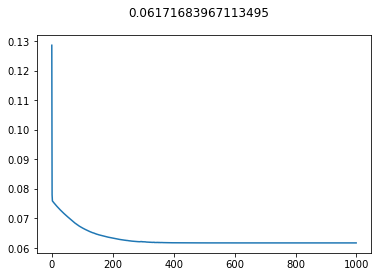

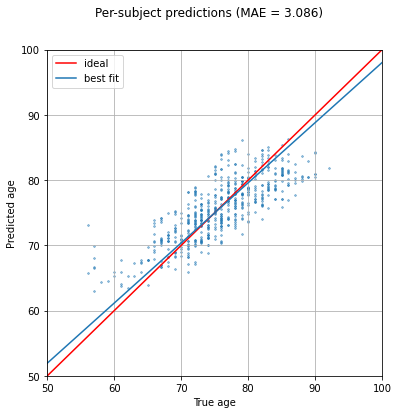

In [196]:
import torch
import torch.nn as nn


model = nn.Linear(1,1)
optim = torch.optim.SGD(model.parameters(), lr=.1)

loss_fun = nn.L1Loss()

X = (torch.from_numpy(Y_pred.mean(axis=-1).reshape(-1,1)) - 50) / 50
y = (torch.from_numpy(Y[:,0]) - 50) / 50

error = list()
for epoch in range(1000):
    optim.zero_grad()
    
    y_pred = model(X).squeeze()
    
    loss = loss_fun(y_pred, y)
    
    loss.backward()
    optim.step()
    
    error.append(loss.item())

plt.plot(error)
plt.suptitle(error[-1])
plt.show()

show_pred(y_pred.detach().numpy() * 50 + 50, Y[:,0])

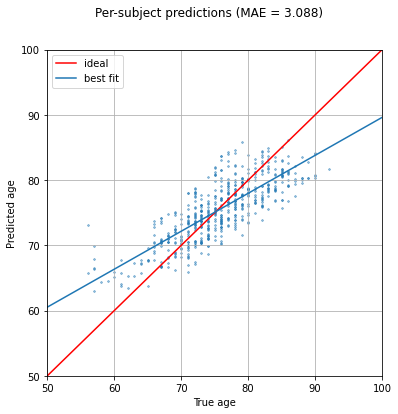

In [90]:
postproc = make_postprocessor(Y_pred.mean(axis=-1), Y[:,0])

show_pred(postproc(Y_pred.mean(axis=-1)), Y[:,0])

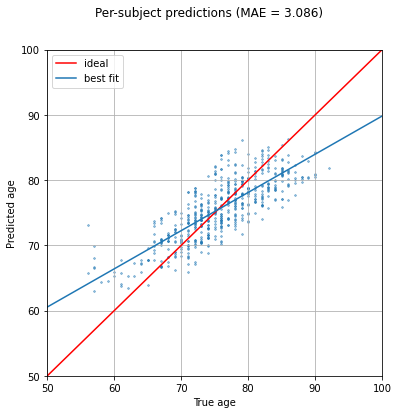

In [106]:
postproc = make_postprocessor_mlp(Y_pred.mean(axis=-1), Y[:,0])

show_pred(postproc(Y_pred.mean(axis=-1)), Y[:,0])

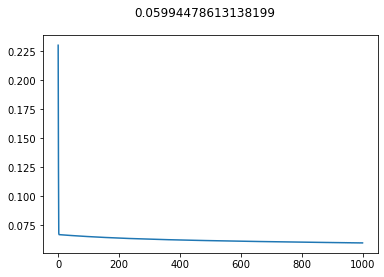

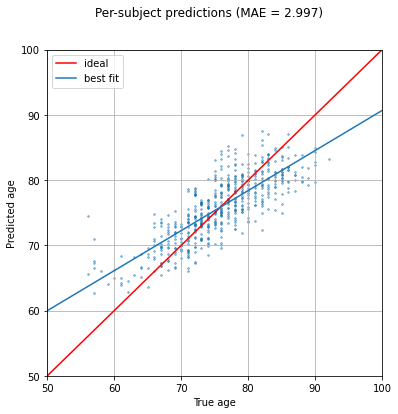

In [119]:
import torch
import torch.nn as nn


model = nn.Linear(Y_pred.shape[-1],1)
optim = torch.optim.SGD(model.parameters(), lr=.01)

loss_fun = nn.L1Loss()

X = (torch.from_numpy(Y_pred) - 50) / 50
y = (torch.from_numpy(Y[:,0]) - 50) / 50

error = list()
for epoch in range(1000):
    optim.zero_grad()
    
    y_pred = model(X).squeeze()
    
    loss = loss_fun(y_pred, y)
    
    loss.backward()
    optim.step()
    
    error.append(loss.item())

plt.plot(error)
plt.suptitle(error[-1])
plt.show()

show_pred(y_pred.detach().numpy() * 50 + 50, Y[:,0])

val MAE:  3.0397937297821045


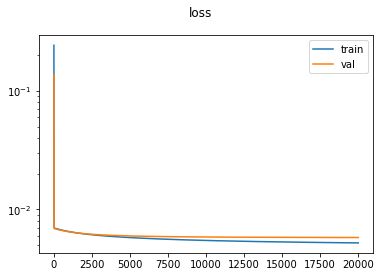

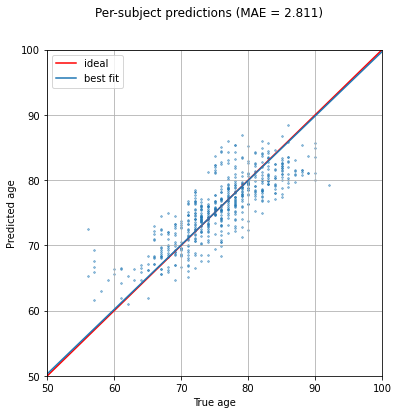

In [217]:
import torch
import torch.nn as nn


model = nn.Linear(Y_pred.shape[-1],1)
optim = torch.optim.SGD(model.parameters(), lr=.01)

# loss_fun = nn.L1Loss()
loss_fun = nn.MSELoss()

data = np.hstack([Y_pred, Y[:,:1]])
np.random.shuffle(data)

X = (torch.from_numpy(data[:,:-1]) - 50) / 50
y = (torch.from_numpy(data[:,-1]) - 50) / 50
s = int(data.shape[0] * 0.8)
X_train, y_train = X[:s], y[:s]
X_val, y_val = X[s:], y[s:]
error = list()
val_error = list()
for epoch in range(20000):
    model.train()
    optim.zero_grad()

    y_pred = model(X_train).squeeze()

    loss = loss_fun(y_pred, y_train)

    loss.backward()
    optim.step()

    error.append(loss.item())

    model.eval()
    y_pred = model(X_val).squeeze()

    val_loss = loss_fun(y_pred, y_val)

    val_error.append(val_loss.item())

print('val MAE: ',(y_pred * 50 - y_val * 50).abs().mean().item())

plt.plot(error, label='train')
plt.plot(val_error, label='val')
plt.legend()
plt.yscale('log')
# plt.suptitle(error[-1])
plt.suptitle('loss')
plt.show()

y_pred = model(X).squeeze()
show_pred(y_pred.detach().numpy() * 50 + 50, y.detach().numpy() * 50 + 50)

------------fold no---------0----------------------
val MAE:  2.9723331928253174
------------fold no---------1----------------------
val MAE:  3.0931761264801025
------------fold no---------2----------------------
val MAE:  2.726968288421631
------------fold no---------3----------------------
val MAE:  2.8566720485687256
------------fold no---------4----------------------
val MAE:  2.999162197113037


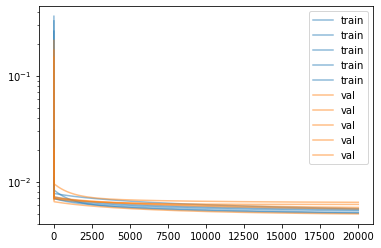

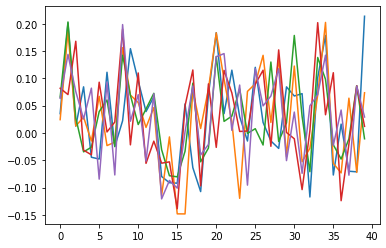

In [358]:
from sklearn.model_selection import KFold

# loss_fun = nn.L1Loss()
loss_fun = nn.MSELoss()

dataset = torch.utils.data.TensorDataset(torch.from_numpy(Y_pred - 50) / 50, torch.from_numpy(Y[:,:1] - 50) / 50)

errors = list()
val_errors = list()
weights = list()
biases = list()

kf = KFold(n_splits=5, shuffle=True)
for fold,(train_idx,test_idx) in enumerate(kf.split(dataset)):
    print('------------fold no---------{}----------------------'.format(fold))

    model = nn.Linear(Y_pred.shape[-1],1)
    optim = torch.optim.SGD(model.parameters(), lr=.01)

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=1000, sampler=train_subsampler
    )
    testloader = torch.utils.data.DataLoader(
        dataset, batch_size=1000, sampler=test_subsampler
    )
    errors.append(list())
    val_errors.append(list())
    for epoch in range(20000):
        for X, y in trainloader:
            model.train()
            optim.zero_grad()

            y_pred = model(X)

            loss = loss_fun(y_pred, y.float())

            loss.backward()
            optim.step()

            errors[-1].append(loss.item())

        for X, y in testloader:
            model.eval()
            y_pred = model(X)

            val_loss = loss_fun(y_pred, y.float())

            val_errors[-1].append(val_loss.item())
    weights.append(model.weight.detach().numpy()[0])
    biases.append(model.bias.detach().numpy()[0])
    print('val MAE: ',(y_pred * 50 - y.float() * 50).abs().mean().item())

for error in errors:
    plt.plot(error, c='tab:blue', alpha=.5, label='train')
for val_error in val_errors:
    plt.plot(val_error, c='tab:orange', alpha=.5, label='val')
plt.legend()
plt.yscale('log')
plt.show()

for w in weights:
    plt.plot(w)
plt.show()

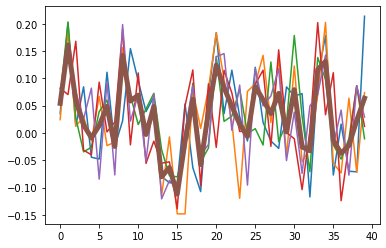

In [359]:
for w in weights:
    plt.plot(w)

plt.plot(np.stack(weights).mean(axis=0), '-', linewidth=5)

plt.show()

val MAE:  2.8078739643096924


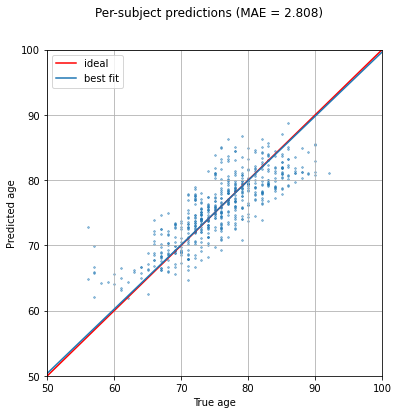

In [372]:
model = nn.Linear(Y_pred.shape[-1],1)
model.weight = nn.Parameter(torch.Tensor(np.stack(weights).mean(axis=0)).unsqueeze(0))
model.bias = nn.Parameter(torch.Tensor([sum(biases) / len(biases),]))

data = np.hstack([Y_pred, Y[:,:1]])
np.random.shuffle(data)

X = (torch.from_numpy(data[:,:-1]) - 50) / 50
y = (torch.from_numpy(data[:,-1]) - 50) / 50

model.eval()
y_pred = model(X).squeeze()

print('val MAE: ',(y_pred * 50 - y.float() * 50).abs().mean().item())
show_pred(y_pred.detach().numpy() * 50 + 50, y.detach().numpy() * 50 + 50)

### Training data

In [336]:
from torch.utils.data import DataLoader

device = torch.device('cpu')

net = torch.load('/home/bruno-pacheco/brain-age/models/brats_model.pt')
net.pooling = nn.AvgPool2d(3)
net = load_from_wandb(net, '32j2aq8b').to(device)
net.eval()

train_data = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix_2mm_split.hdf5', dataset='train')

train_dataloader = DataLoader(train_data, batch_size=40, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(train_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

Y = np.stack(Y)
Y_pred = np.stack(Y_pred)

Ys = {
    'pred': Y_pred,
    'true': Y
}
with open(PROJ_ROOT/'data/preds/unet_brats_train.pkl', 'wb') as f:
    pickle.dump(Ys, f)

Per-image MAE   = 0.1594
Per-subject MAE = 0.1463 (mean agg)
Per-subject MAE = 0.1460 (median agg)


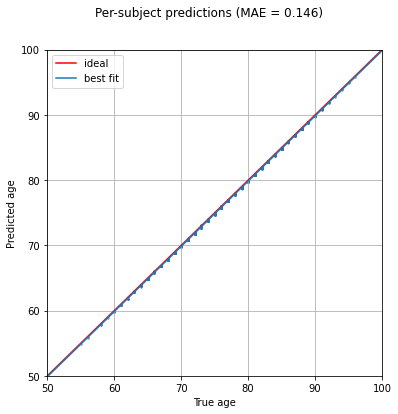

In [337]:
with open(PROJ_ROOT/'data/preds/unet_brats_train.pkl', 'rb') as f:
    Ys = pickle.load(f)

Y_train = Ys['true']
Y_train_pred = Ys['pred']

compute_scores(Y_train_pred, Y_train)

show_pred(Y_train_pred.mean(axis=-1), Y_train[:,0])

val MAE:  3.3810174465179443


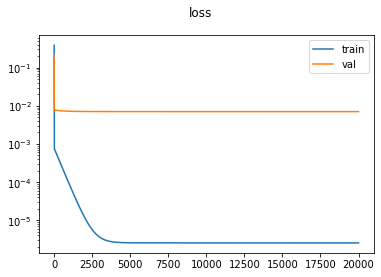

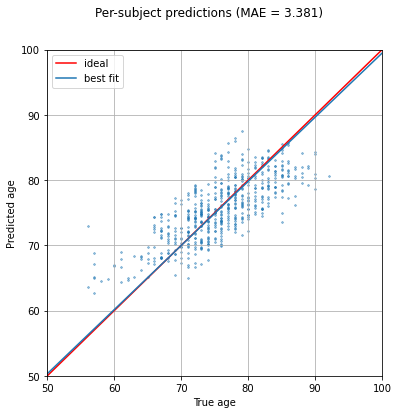

In [340]:
import torch
import torch.nn as nn


model = nn.Linear(Y_pred.shape[-1],1)
optim = torch.optim.SGD(model.parameters(), lr=.01)

# loss_fun = nn.L1Loss()
loss_fun = nn.MSELoss()

data = np.hstack([Y_pred, Y[:,:1]])
np.random.shuffle(data)

X = (torch.from_numpy(data[:,:-1]) - 50) / 50
y = (torch.from_numpy(data[:,-1]) - 50) / 50
s = int(data.shape[0] * 0.8)

X_train, y_train = torch.from_numpy(Y_train_pred - 50) / 50, torch.from_numpy(Y_train[:,0] - 50) / 50
X_val, y_val = torch.from_numpy(Y_pred - 50) / 50, torch.from_numpy(Y[:,0] - 50) / 50

error = list()
val_error = list()
for epoch in range(20000):
    model.train()
    optim.zero_grad()

    y_pred = model(X_train).squeeze()

    loss = loss_fun(y_pred, y_train)

    loss.backward()
    optim.step()

    error.append(loss.item())

    model.eval()
    y_pred = model(X_val).squeeze()

    val_loss = loss_fun(y_pred, y_val)

    val_error.append(val_loss.item())

print('val MAE: ',(y_pred * 50 - y_val * 50).abs().mean().item())

plt.plot(error, label='train')
plt.plot(val_error, label='val')
plt.legend()
plt.yscale('log')
# plt.suptitle(error[-1])
plt.suptitle('loss')
plt.show()

y_pred = model(X).squeeze()
show_pred(y_pred.detach().numpy() * 50 + 50, y.detach().numpy() * 50 + 50)

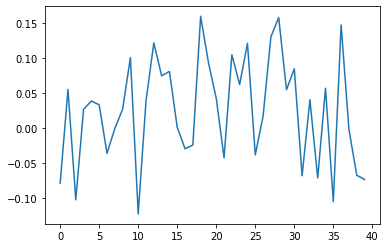

In [341]:
plt.plot(model.weight.detach().numpy()[0])

### Slice bias correction

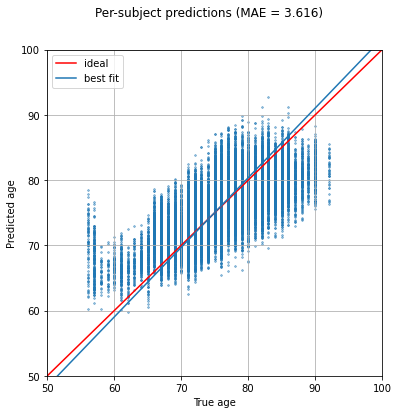

In [402]:
show_pred(Y_pred.flatten(), Y.flatten())

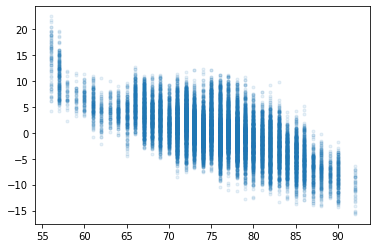

In [410]:
delta = Y_pred.flatten() - Y.flatten()
plt.plot(Y.flatten(), delta, '.', linewidth=0, alpha=.1)

In [411]:
delta.mean()

0.07983803

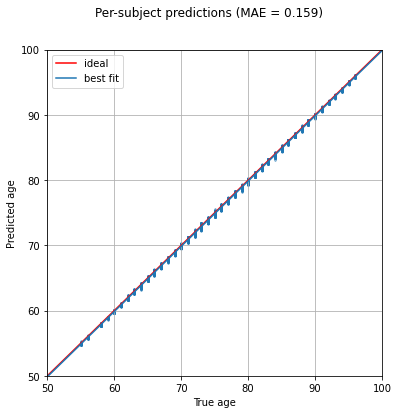

In [406]:
show_pred(Y_train_pred.flatten(), Y_train.flatten())

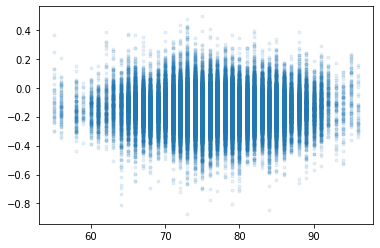

In [408]:
delta = Y_train_pred.flatten() - Y_train.flatten()
plt.plot(Y_train.flatten(), delta, '.', linewidth=0, alpha=0.1)

In [405]:
delta.mean()

-0.14573307

### BrainSeg-nnUNet

In [39]:
net = torch.load('/home/bruno-pacheco/brain-age/models/brainseg_model.pt')
net.pooling = nn.AvgPool2d(3)
net = load_from_wandb(net, '3el0gwdc').to(device)
net.eval()
net

BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

In [40]:
len(val_data) / 40

561.0

In [41]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=40, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

Y = np.stack(Y)
Y_pred = np.stack(Y_pred)

# some subjects are 0-aged
# Y_pred = Y_pred[(Y != 0).any(axis=-1)]
# Y = Y[(Y != 0).any(axis=-1)]

Per-image MAE   = 3.6799
Per-subject MAE = 3.1978 (mean agg)
Per-subject MAE = 3.1867 (median agg)


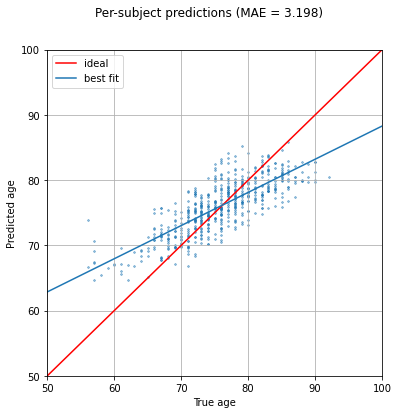

In [168]:
# Ys = {
#     'pred': Y_pred,
#     'true': Y
# }
# with open(PROJ_ROOT/'data/preds/unet_brainseg.pkl', 'wb') as f:
#     pickle.dump(Ys, f)

with open(PROJ_ROOT/'data/preds/unet_brainseg.pkl', 'rb') as f:
    Ys = pickle.load(f)

Y = Ys['true']
Y_pred = Ys['pred']

compute_scores(Y_pred, Y)

show_pred(Y_pred.mean(axis=-1), Y[:,0])

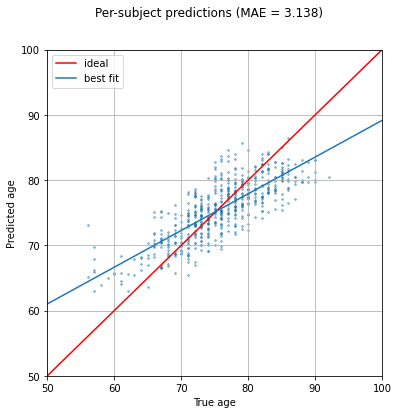

In [92]:
postproc = make_postprocessor(Y_pred.mean(axis=-1), Y[:,0])

show_pred(postproc(Y_pred.mean(axis=-1)), Y[:,0])

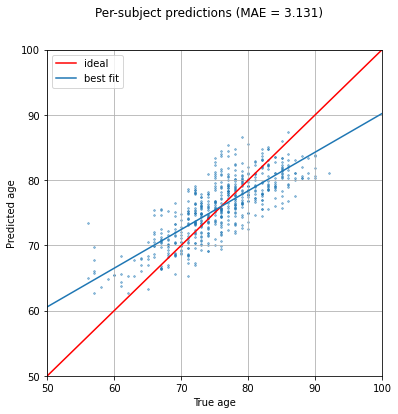

In [108]:
postproc = make_postprocessor_mlp(Y_pred.mean(axis=-1), Y[:,0])

show_pred(postproc(Y_pred.mean(axis=-1)), Y[:,0])

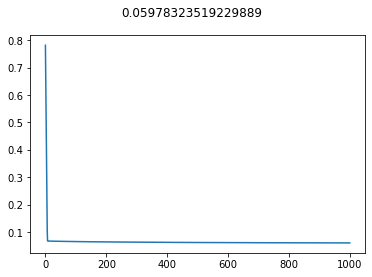

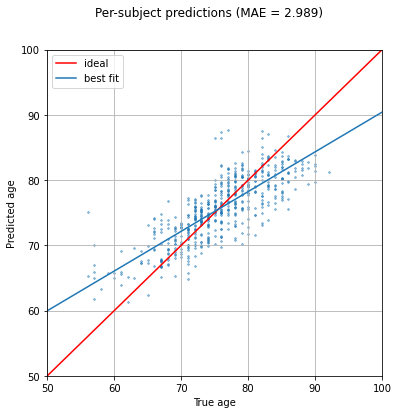

In [169]:
import torch
import torch.nn as nn


model = nn.Linear(Y_pred.shape[-1],1)
optim = torch.optim.SGD(model.parameters(), lr=.01)

loss_fun = nn.L1Loss()

X = (torch.from_numpy(Y_pred) - 50) / 50
y = (torch.from_numpy(Y[:,0]) - 50) / 50

error = list()
for epoch in range(1000):
    optim.zero_grad()
    
    y_pred = model(X).squeeze()
    
    loss = loss_fun(y_pred, y)
    
    loss.backward()
    optim.step()
    
    error.append(loss.item())

plt.plot(error)
plt.suptitle(error[-1])
plt.show()

show_pred(y_pred.detach().numpy() * 50 + 50, Y[:,0])

val MAE:  3.0007388591766357


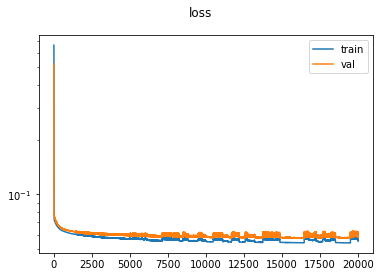

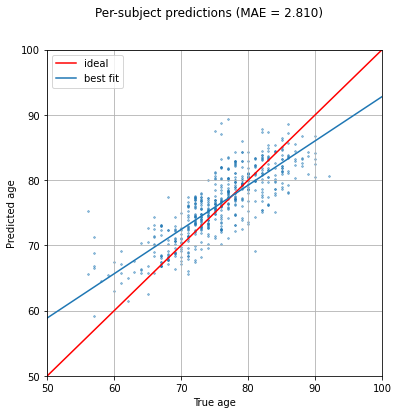

In [179]:
import torch
import torch.nn as nn


model = nn.Linear(Y_pred.shape[-1],1)
optim = torch.optim.SGD(model.parameters(), lr=.01)

loss_fun = nn.L1Loss()

data = np.hstack([Y_pred, Y[:,:1]])
np.random.shuffle(data)

X = (torch.from_numpy(data[:,:-1]) - 50) / 50
y = (torch.from_numpy(data[:,-1]) - 50) / 50

s = 448
X_train, y_train = X[:s], y[:s]
X_val, y_val = X[s:], y[s:]
error = list()
val_error = list()
for epoch in range(20000):
    model.train()
    optim.zero_grad()
    
    y_pred = model(X_train).squeeze()
    
    loss = loss_fun(y_pred, y_train)
    
    loss.backward()
    optim.step()
    
    error.append(loss.item())
    
    model.eval()
    y_pred = model(X_val).squeeze()
    
    val_loss = loss_fun(y_pred, y_val)
    
    val_error.append(val_loss.item())

print('val MAE: ',(y_pred * 50 - y_val * 50).abs().mean().item())
    
plt.plot(error, label='train')
plt.plot(val_error, label='val')
plt.legend()
plt.yscale('log')
# plt.suptitle(error[-1])
plt.suptitle('loss')
plt.show()

y_pred = model(X).squeeze()
show_pred(y_pred.detach().numpy() * 50 + 50, y.detach().numpy() * 50 + 50)

### ResNet

In [50]:
net = models.resnet50(pretrained=True)
net.fc = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Linear(1024, 1))
net = load_from_wandb(net, '3gvx067d').to(device)
net.eval()
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [51]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=40, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X.repeat(1,3,1,1)).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

Y = np.stack(Y)
Y_pred = np.stack(Y_pred)[...,0]

# some subjects are 0-aged
# Y_pred = Y_pred[(Y != 0).any(axis=-1)]
# Y = Y[(Y != 0).any(axis=-1)]

Per-image MAE   = 3.8774
Per-subject MAE = 3.3249 (mean agg)
Per-subject MAE = 3.3534 (median agg)


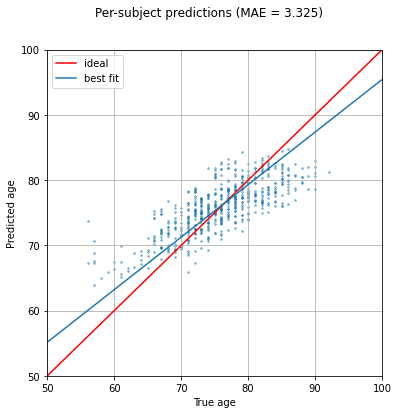

In [199]:
# Ys = {
#     'pred': Y_pred,
#     'true': Y
# }
# with open(PROJ_ROOT/'data/preds/resnet_imagenet.pkl', 'wb') as f:
#     pickle.dump(Ys, f)

with open(PROJ_ROOT/'data/preds/resnet_imagenet.pkl', 'rb') as f:
    Ys = pickle.load(f)

Y = Ys['true']
Y_pred = Ys['pred']

compute_scores(Y_pred, Y)

show_pred(Y_pred.mean(axis=-1), Y[:,0])

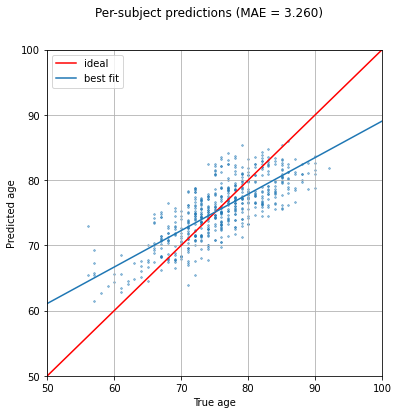

In [94]:
postproc = make_postprocessor(Y_pred.mean(axis=-1), Y[:,0])

show_pred(postproc(Y_pred.mean(axis=-1)), Y[:,0])

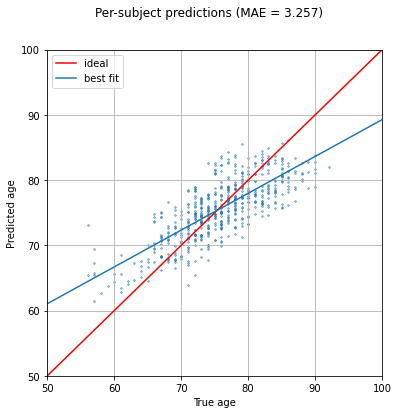

In [110]:
postproc = make_postprocessor_mlp(Y_pred.mean(axis=-1), Y[:,0])

show_pred(postproc(Y_pred.mean(axis=-1)), Y[:,0])

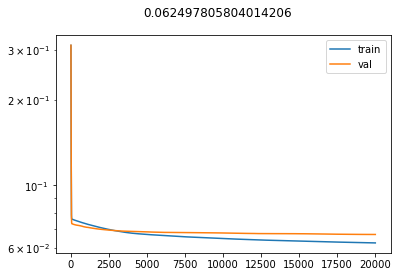

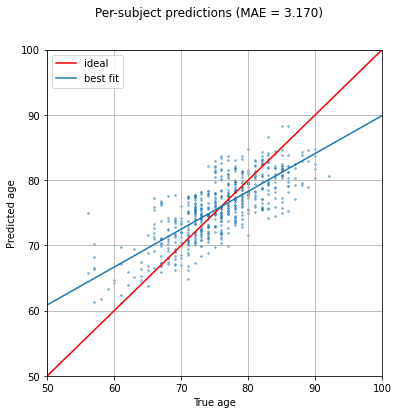

In [167]:
import torch
import torch.nn as nn


model = nn.Linear(Y_pred.shape[-1],1)
optim = torch.optim.SGD(model.parameters(), lr=.001)

loss_fun = nn.L1Loss()

data = np.hstack([Y_pred, Y[:,:1]])
np.random.shuffle(data)

X = (torch.from_numpy(data[:,:-1]) - 50) / 50
y = (torch.from_numpy(data[:,-1]) - 50) / 50

s = 448
X_train, y_train = X[:s], y[:s]
X_val, y_val = X[s:], y[s:]
error = list()
val_error = list()
for epoch in range(20000):
    model.train()
    optim.zero_grad()
    
    y_pred = model(X_train).squeeze()
    
    loss = loss_fun(y_pred, y_train)
    
    loss.backward()
    optim.step()
    
    error.append(loss.item())
    
    model.eval()
    y_pred = model(X_val).squeeze()
    
    val_loss = loss_fun(y_pred, y_val)
    
    val_error.append(val_loss.item())

plt.plot(error, label='train')
plt.plot(val_error, label='val')
plt.legend()
plt.yscale('log')
plt.suptitle(error[-1])
plt.show()

y_pred = model(X).squeeze()
show_pred(y_pred.detach().numpy() * 50 + 50, y.detach().numpy() * 50 + 50)

## Normality tests

### Validation set

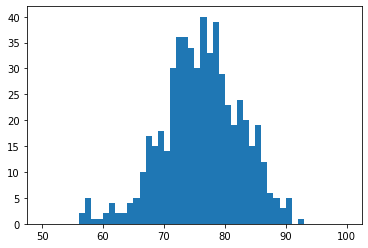

In [391]:
plt.hist(Y[:,0], bins=50, range=(50,100))
plt.show()

In [377]:
from scipy.stats import shapiro

shapiro(Y[:,0])

ShapiroResult(statistic=0.9895111918449402, pvalue=0.0004879697225987911)

In [382]:
from scipy.stats import anderson

anderson(Y[:,0], dist='norm')

AndersonResult(statistic=1.1407271084838158, critical_values=array([0.572, 0.651, 0.781, 0.912, 1.084]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [383]:
from scipy.stats import kstest

kstest(Y[:,0], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

### Train set

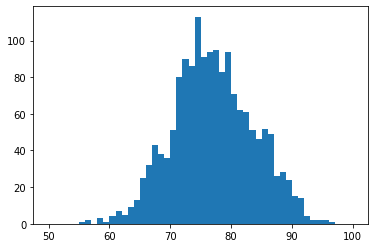

In [390]:
plt.hist(Y_train[:,0], bins=50, range=(50,100))
plt.show()

In [380]:
from scipy.stats import shapiro

shapiro(Y_train[:,0])

ShapiroResult(statistic=0.9954016208648682, pvalue=7.973793253768235e-05)

In [381]:
from scipy.stats import anderson

anderson(Y_train[:,0], dist='norm')

AndersonResult(statistic=2.803329657996983, critical_values=array([0.575, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [384]:
from scipy.stats import kstest

kstest(Y_train[:,0], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)